In [2]:
#!pip install --user geoviews
!pip install --user xarray==0.10.0 netcdf4

     |████████████████████████████████| 358kB 16.9MB/s eta 0:00:01
     |████████████████████████████████| 4.1MB 23.4MB/s eta 0:00:01
     |████████████████████████████████| 317kB 24.6MB/s eta 0:00:01


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd
from matplotlib import animation
# import geoviews as gv
# import geoviews.feature as gf

In [17]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'

In [3]:
%matplotlib inline

In [4]:
ds = xr.open_mfdataset('cloudstor/Data/himawari_sst/NWS/NWS_2019*.nc')
ds

<xarray.Dataset>
Dimensions:                  (lat: 1251, lon: 1251, time: 6502)
Coordinates:
  * lat                      (lat) float32 -5.0 -5.0199966 -5.040001 ...
  * lon                      (lon) float32 110.0 110.02 110.04 110.06 110.08 ...
  * time                     (time) datetime64[ns] 2019-01-01T00:00:17 ...
Data variables:
    sea_surface_temperature  (time, lat, lon) float64 dask.array<shape=(6502, 1251, 1251), chunksize=(1, 1251, 1251)>
    wind_speed               (time, lat, lon) float64 dask.array<shape=(6502, 1251, 1251), chunksize=(1, 1251, 1251)>
    l2p_flags                (time, lat, lon) float64 dask.array<shape=(6502, 1251, 1251), chunksize=(1, 1251, 1251)>
    quality_level            (time, lat, lon) float64 dask.array<shape=(6502, 1251, 1251), chunksize=(1, 1251, 1251)>
    solar_zenith_angle       (time, lat, lon) float64 dask.array<shape=(6502, 1251, 1251), chunksize=(1, 1251, 1251)>
Attributes:
    Conventions:                CF-1.4,Unidata Observation 

In [5]:
ds.time.values[0], ds.time.values[-1]

(numpy.datetime64('2019-01-01T00:00:17.000000000'),
 numpy.datetime64('2019-09-28T23:00:17.000000000'))

In [6]:
temp = ds.sea_surface_temperature.where(ds.quality_level>4, np.nan)


In [7]:
# Load some bathy data
dsz = xr.open_dataset('cloudstor/Data/Bathymetry/TimorSea_GAWEL_Multi_GEBCO_Combined_DEM.nc')
# dsz.set_coords({'X':dsz.X,'Y':dsz.Y})
# dsz.topo.swap_dims({'ny':dsz.Y.values, 'nx':dsz.X.values})
topo = xr.DataArray(dsz.topo.values, dims=('Y','X'), coords={'X':dsz.X.values, 'Y':dsz.Y.values})

In [8]:
def plot_sst_scene(ax, temp,t1,t2, xlims=(112,128), ylims=(-24,-12), cbar=True):
    mu_temp = temp.sel(time=slice(t1,t2)).mean(axis=0)
    dTdx,dTdy = np.gradient(mu_temp, 2e3,2e3)

    dT = np.abs(dTdx+1j*dTdy)
    # plt.pcolormesh(temp.lon, temp.lat, dT, cmap='Blues',vmin=0, vmax=1e-4)
    P = mu_temp.plot(ax=ax, cmap='Spectral_r',vmin=273+23,vmax=273+31, add_colorbar=cbar )
    C = plt.contour(temp.lon, temp.lat, dT, [4e-5,],colors='k',linewidths=0.5)
    
    topo.sel(X=slice(xlims[0],xlims[1]), Y=slice(ylims[0],ylims[1])).plot.contour(\
                    levels=[-1000,-200],colors='0.5',linewidths=1, linestyles='--')
    
    plt.ylim(ylims)
    plt.xlim(xlims)
    # plt.ylim(-22,-16)
    # plt.xlim(114,120)
    plt.gca().set_aspect('equal')
    T = plt.text(116,-23,'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    {} - {}'.format(t1,t2))
    
    plt.tight_layout()
    
    return P, C, T

def plot_sstgrad_scene(ax, temp,t1,t2, xlims=(112,128), ylims=(-24,-12), cbar=True):
    mu_temp = temp.sel(time=slice(t1,t2)).mean(axis=0)
    dTdx,dTdy = np.gradient(mu_temp, 2e3,2e3)

    dT = np.abs(dTdx+1j*dTdy)
    C= plt.pcolormesh(temp.lon, temp.lat, dT, cmap='bone_r',vmin=1e-5, vmax=1e-4)
    #P = mu_temp.plot(ax=ax, cmap='Spectral_r',vmin=273+23,vmax=273+31, add_colorbar=cbar )
    #C = plt.contour(temp.lon, temp.lat, dT, [4e-5,],colors='k',linewidths=0.5)
    if cbar:
        plt.colorbar()
    
    topo.sel(X=slice(xlims[0],xlims[1]), Y=slice(ylims[0],ylims[1])).plot.contour(\
                    levels=[-1000,-200],colors='0.5',linewidths=1, linestyles='--')
    
    plt.ylim(ylims)
    plt.xlim(xlims)
    # plt.ylim(-22,-16)
    # plt.xlim(114,120)
    plt.gca().set_aspect('equal')
    T = plt.text(116,-23,'Himawari-8 Sea Surface Temperature gradient [K/m]\nAverage Time:\n    {} - {}'.format(t1,t2))
    
    plt.tight_layout()
    
    return C, T
    


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff0883a0358>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature gradient [K/m]\nAverage Time:\n    2019-09-01 12:00:00 - 2019-09-04 12:00:00'))

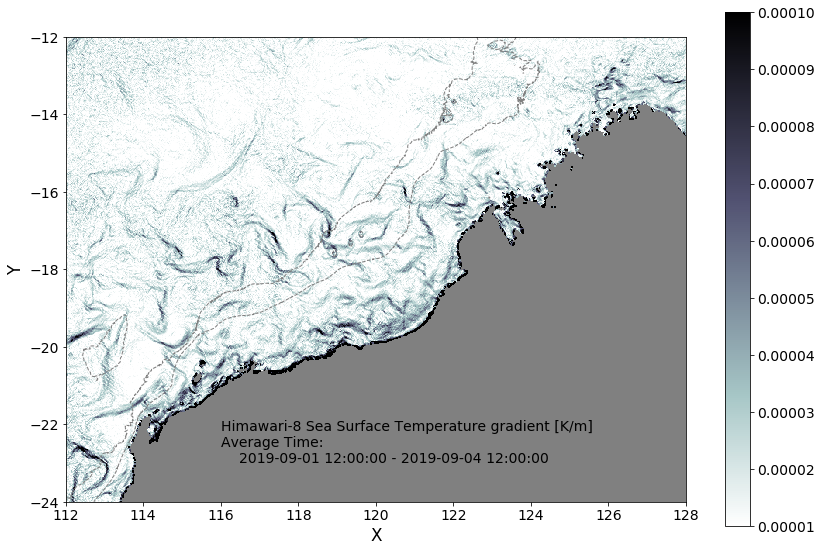

In [18]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, temp,'2019-09-01 12:00:00','2019-09-04 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff0a967d4e0>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-03-26 12:00:00 - 2019-03-29 12:00:00'))

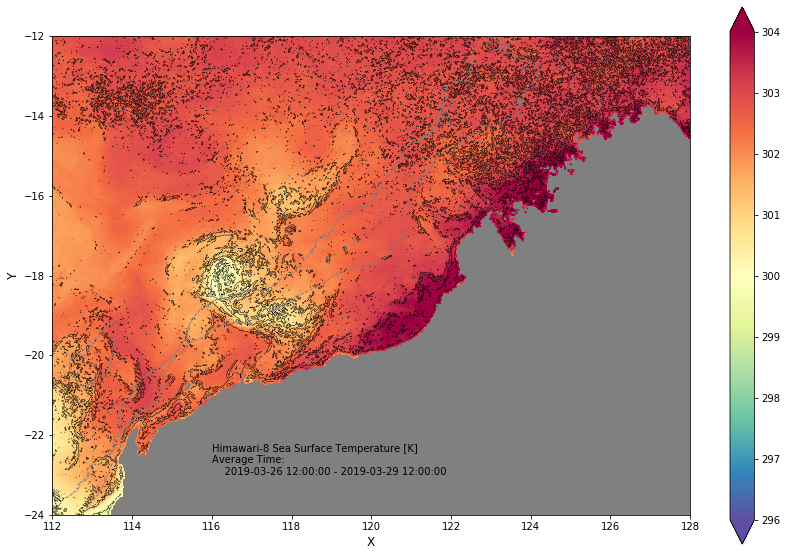

In [10]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-03-26 12:00:00','2019-03-29 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff0a1b63710>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-04-01 12:00:00 - 2019-04-04 12:00:00'))

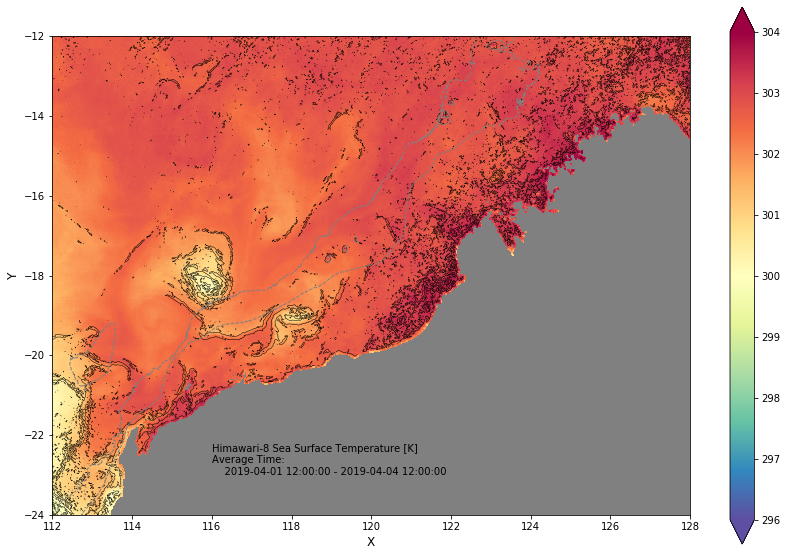

In [11]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-04-01 12:00:00','2019-04-04 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff0a96d3668>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-04-15 12:00:00 - 2019-04-18 12:00:00'))

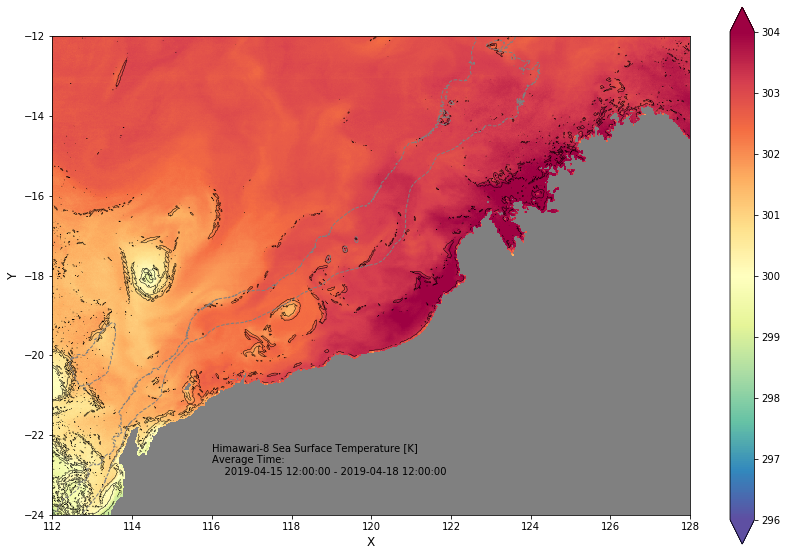

In [12]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-04-15 12:00:00','2019-04-18 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff097939390>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-05-01 12:00:00 - 2019-05-04 12:00:00'))

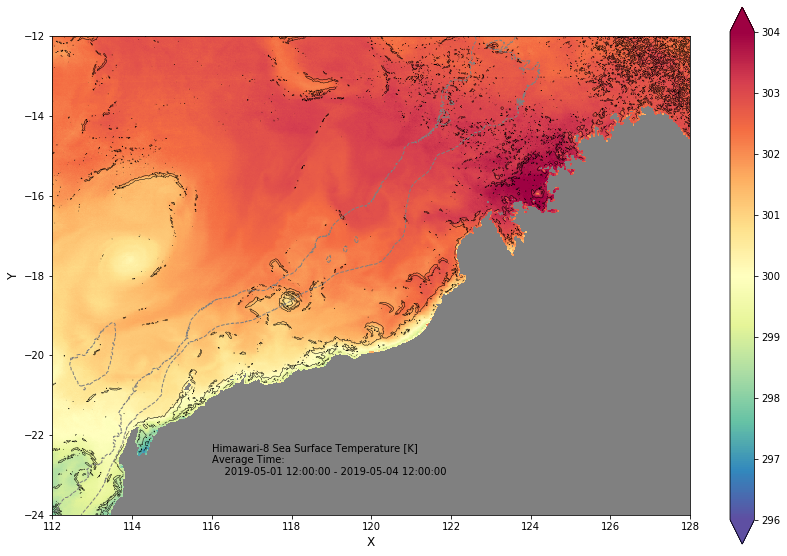

In [13]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-05-01 12:00:00','2019-05-04 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff092973908>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-05-01 12:00:00 - 2019-05-04 12:00:00'))

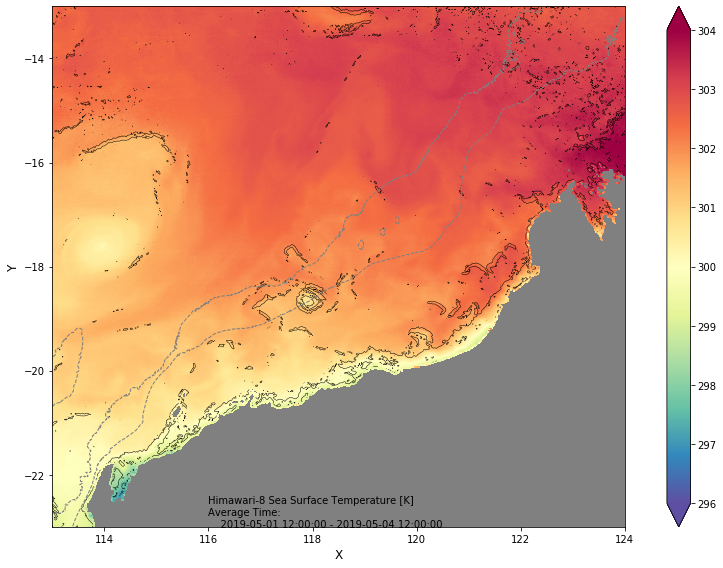

In [14]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-05-01 12:00:00','2019-05-04 12:00:00', xlims=(113,124), ylims=(-23,-13))

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff08da3f7b8>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-04-01 12:00:00 - 2019-04-04 12:00:00'))

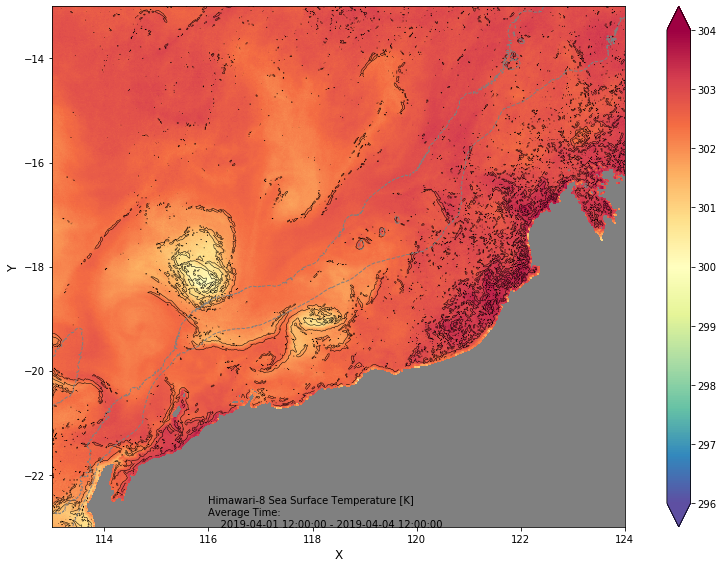

In [15]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-04-01 12:00:00','2019-04-04 12:00:00', xlims=(113,124), ylims=(-23,-13))

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-28 00:00:00 2019-05-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-29 00:00:00 2019-06-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-30 00:00:00 2019-06-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-31 00:00:00 2019-06-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-01 00:00:00 2019-06-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-02 00:00:00 2019-06-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-03 00:00:00 2019-06-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-04 00:00:00 2019-06-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-05 00:00:00 2019-06-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-06 00:00:00 2019-06-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-07 00:00:00 2019-06-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-08 00:00:00 2019-06-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-09 00:00:00 2019-06-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-10 00:00:00 2019-06-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-11 00:00:00 2019-06-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-12 00:00:00 2019-06-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-13 00:00:00 2019-06-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-14 00:00:00 2019-06-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-15 00:00:00 2019-06-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-16 00:00:00 2019-06-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-17 00:00:00 2019-06-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-18 00:00:00 2019-06-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-19 00:00:00 2019-06-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-20 00:00:00 2019-06-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-21 00:00:00 2019-06-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-22 00:00:00 2019-06-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-23 00:00:00 2019-06-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-24 00:00:00 2019-06-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-25 00:00:00 2019-06-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-26 00:00:00 2019-06-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-27 00:00:00 2019-06-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-28 00:00:00 2019-07-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-29 00:00:00 2019-07-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-30 00:00:00 2019-07-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-01 00:00:00 2019-07-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-02 00:00:00 2019-07-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-03 00:00:00 2019-07-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-04 00:00:00 2019-07-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-05 00:00:00 2019-07-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-06 00:00:00 2019-07-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-07 00:00:00 2019-07-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-08 00:00:00 2019-07-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-09 00:00:00 2019-07-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-10 00:00:00 2019-07-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-11 00:00:00 2019-07-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-12 00:00:00 2019-07-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-13 00:00:00 2019-07-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-14 00:00:00 2019-07-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-15 00:00:00 2019-07-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-16 00:00:00 2019-07-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-17 00:00:00 2019-07-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-18 00:00:00 2019-07-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-19 00:00:00 2019-07-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-20 00:00:00 2019-07-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-21 00:00:00 2019-07-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-22 00:00:00 2019-07-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-23 00:00:00 2019-07-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-24 00:00:00 2019-07-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-25 00:00:00 2019-07-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-26 00:00:00 2019-07-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-27 00:00:00 2019-07-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-28 00:00:00 2019-07-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-29 00:00:00 2019-08-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-30 00:00:00 2019-08-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-31 00:00:00 2019-08-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-01 00:00:00 2019-08-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-02 00:00:00 2019-08-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-03 00:00:00 2019-08-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-04 00:00:00 2019-08-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-05 00:00:00 2019-08-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-06 00:00:00 2019-08-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-07 00:00:00 2019-08-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-08 00:00:00 2019-08-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-09 00:00:00 2019-08-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-10 00:00:00 2019-08-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-11 00:00:00 2019-08-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-12 00:00:00 2019-08-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-13 00:00:00 2019-08-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-14 00:00:00 2019-08-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-15 00:00:00 2019-08-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-16 00:00:00 2019-08-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-17 00:00:00 2019-08-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-18 00:00:00 2019-08-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-19 00:00:00 2019-08-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-20 00:00:00 2019-08-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-21 00:00:00 2019-08-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-22 00:00:00 2019-08-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-23 00:00:00 2019-08-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-24 00:00:00 2019-08-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-25 00:00:00 2019-08-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-26 00:00:00 2019-08-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-27 00:00:00 2019-08-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-28 00:00:00 2019-08-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-29 00:00:00 2019-09-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-30 00:00:00 2019-09-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-31 00:00:00 2019-09-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-01 00:00:00 2019-09-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-02 00:00:00 2019-09-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-03 00:00:00 2019-09-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-04 00:00:00 2019-09-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-05 00:00:00 2019-09-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-06 00:00:00 2019-09-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-07 00:00:00 2019-09-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-08 00:00:00 2019-09-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-09 00:00:00 2019-09-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-10 00:00:00 2019-09-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-11 00:00:00 2019-09-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-12 00:00:00 2019-09-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-13 00:00:00 2019-09-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-14 00:00:00 2019-09-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-15 00:00:00 2019-09-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-16 00:00:00 2019-09-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-17 00:00:00 2019-09-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-18 00:00:00 2019-09-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-19 00:00:00 2019-09-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-20 00:00:00 2019-09-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-21 00:00:00 2019-09-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


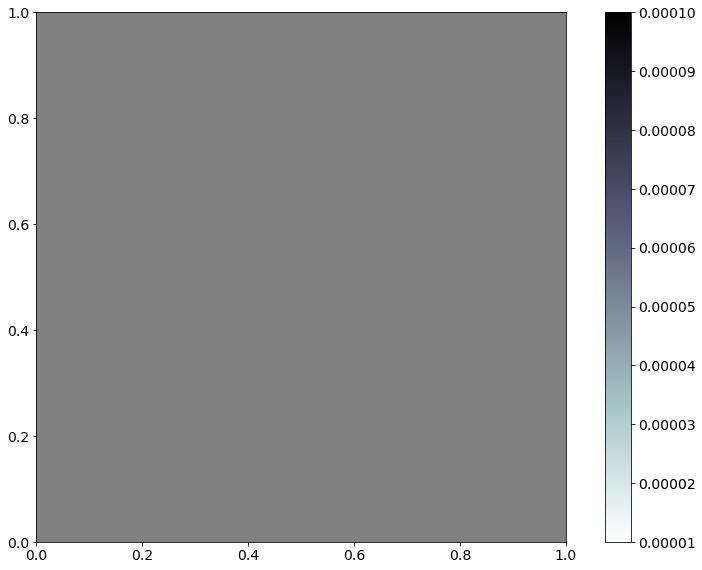

In [19]:
# Make a movie
#dates = pd.date_range('2019-01-01', '2019-06-30',freq='D')
dates = pd.date_range('2019-05-28', '2019-09-24',freq='D')

plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
C, T = plot_sstgrad_scene(ax, temp,dates[0],dates[3],)

# def update_scene(ii):
#     t1 = dates[ii]
#     t2 = dates[ii+3]
for t1,t2 in zip(dates[0:-3], dates[3::]):
    print(t1,t2)
    C, T = plot_sstgrad_scene(ax, temp,t1,t2, cbar=False)
    outfile = 'cloudstor/ProjectsActive/TIDE/FIGURES/SSTgrad_{}.png'.format(t1)
    plt.savefig(outfile, dpi=90)
    plt.cla()

In [ ]:
# Make a movie
#dates = pd.date_range('2019-01-01', '2019-06-30',freq='D')
dates = pd.date_range('2019-06-30', '2019-09-24',freq='D')


plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
P, C, T = plot_sst_scene(ax, temp,dates[0],dates[3],)

# def update_scene(ii):
#     t1 = dates[ii]
#     t2 = dates[ii+3]
for t1,t2 in zip(dates[0:-3], dates[3::]):
    print(t1,t2)
    P, C, T = plot_sst_scene(ax, temp,t1,t2, cbar=False)
    outfile = 'cloudstor/ProjectsActive/TIDE/FIGURES/SST_{}.png'.format(t1)
    plt.savefig(outfile, dpi=150)
    plt.cla()

